Analyzing Open Street Maps data with apache spark

analyze ways in Hungary's OSM data
https://labs.mapbox.com/mapping/osm-data-model/#ways

In [224]:
import findspark
findspark.init()
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [225]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

converted osm pbf to parquet files for better use with spark
spark unable to auto determine the correct data type from the converted parquet files so defining schema

In [226]:
way_schema = StructType([StructField("id",LongType(),True),
    StructField("version",IntegerType(),True),
    StructField("timestamp",LongType(),True),
    StructField("changeset",LongType(),True),
    StructField("uid",IntegerType(),True),
    StructField("user_sid",StringType(),True),
    StructField("tags",ArrayType(StructType([StructField("key",StringType(),True),StructField("value",StringType(),True)]),True),True),
    StructField("nodes",ArrayType(StructType([StructField("index",IntegerType(),True),StructField("nodeId",LongType(),True)]),True),True)])

In [227]:
# generalize the path 
way_df = spark.read.schema(way_schema).parquet("/Users/mayankbaid/Downloads/hungary_osm/20190430-hungary.osm.pbf.way.parquet")

In [228]:
way_df.printSchema()
# register temporary table
way_df.createOrReplaceTempView("ways")

root
 |-- id: long (nullable = true)
 |-- version: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- changeset: long (nullable = true)
 |-- uid: integer (nullable = true)
 |-- user_sid: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- nodes: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: integer (nullable = true)
 |    |    |-- nodeId: long (nullable = true)



In [229]:
way_df.select("tags").show(2,truncate=False)

+---------------------------------------------------+
|tags                                               |
+---------------------------------------------------+
|[[highway, residential], [name, Honvéd utca]]      |
|[[highway, residential], [name, Szent István utca]]|
+---------------------------------------------------+
only showing top 2 rows



In [230]:
way_tags = way_df.select("id",explode("tags").alias("ex_tags")) 

In [231]:
way_tags.printSchema()

root
 |-- id: long (nullable = true)
 |-- ex_tags: struct (nullable = true)
 |    |-- key: string (nullable = true)
 |    |-- value: string (nullable = true)



In [232]:
df_highways = way_tags.filter("ex_tags.key == 'highway'")

In [233]:
# different types of highways
df_highways.groupBy("ex_tags.value").count().orderBy("count",ascending=False).show(df_highways.count(),truncate=False)

+----------------------+------+
|value                 |count |
+----------------------+------+
|track                 |234744|
|residential           |166677|
|service               |103466|
|footway               |58941 |
|path                  |42009 |
|secondary             |26259 |
|primary               |20832 |
|unclassified          |19261 |
|tertiary              |17925 |
|steps                 |7840  |
|cycleway              |7233  |
|motorway              |3397  |
|living_street         |3080  |
|pedestrian            |2686  |
|platform              |2232  |
|motorway_link         |2093  |
|trunk                 |1176  |
|primary_link          |1168  |
|construction          |1016  |
|trunk_link            |869   |
|secondary_link        |672   |
|proposed              |535   |
|tertiary_link         |488   |
|road                  |423   |
|raceway               |156   |
|corridor              |122   |
|rest_area             |87    |
|bridleway             |83    |
|abandon

In [234]:
way_tags.filter((col("ex_tags.key") == 'highway') & (col("ex_tags.value") == 'traffic_signals')).show(truncate=False)

+---------+--------------------------+
|id       |ex_tags                   |
+---------+--------------------------+
|520994975|[highway, traffic_signals]|
|520994976|[highway, traffic_signals]|
|520994977|[highway, traffic_signals]|
|520994978|[highway, traffic_signals]|
|521002726|[highway, traffic_signals]|
|521002727|[highway, traffic_signals]|
|521002728|[highway, traffic_signals]|
|521002729|[highway, traffic_signals]|
|521002730|[highway, traffic_signals]|
+---------+--------------------------+



In [235]:
# analyzing a few rows where tag[highway] == no; seems like a data quality issue! 
# absence of highway tag confirms it is not a highways in other cases
way_df.filter('id == 392337135').show(truncate=False)
way_df.filter('id == 521002730').show(truncate=False)

+---------+-------+-------------+---------+-------+--------+------------------------------------------------------+------------------------------------------------------------------------------------+
|id       |version|timestamp    |changeset|uid    |user_sid|tags                                                  |nodes                                                                               |
+---------+-------+-------------+---------+-------+--------+------------------------------------------------------+------------------------------------------------------------------------------------+
|392337135|1      |1453231966000|36686990 |2100547|hadidoki|[[highway, no], [source, turistautak.hu], [traces, 1]]|[[0, 1373930208], [1, 3955706801], [2, 3955706799], [3, 3955706794], [4, 348240456]]|
+---------+-------+-------------+---------+-------+--------+------------------------------------------------------+---------------------------------------------------------------------------------

In [236]:
# different highways and their occurences via spark SQL

spark.sql("""select 
              w.exp_t.value highway_type, 
              count(w.exp_t.value) count 
          from 
              (select id, explode(tags) exp_t from ways) w  
          where 
              exp_t.key == 'highway' 
          group by(w.exp_t.value) 
          order by(count) desc""").show(df_highways.count(),truncate=False)

+----------------------+------+
|highway_type          |count |
+----------------------+------+
|track                 |234744|
|residential           |166677|
|service               |103466|
|footway               |58941 |
|path                  |42009 |
|secondary             |26259 |
|primary               |20832 |
|unclassified          |19261 |
|tertiary              |17925 |
|steps                 |7840  |
|cycleway              |7233  |
|motorway              |3397  |
|living_street         |3080  |
|pedestrian            |2686  |
|platform              |2232  |
|motorway_link         |2093  |
|trunk                 |1176  |
|primary_link          |1168  |
|construction          |1016  |
|trunk_link            |869   |
|secondary_link        |672   |
|proposed              |535   |
|tertiary_link         |488   |
|road                  |423   |
|raceway               |156   |
|corridor              |122   |
|rest_area             |87    |
|bridleway             |83    |
|abandon

In [281]:
highways_pandas = df_highways.groupBy("ex_tags.value").count().orderBy("count",ascending=False).toPandas()

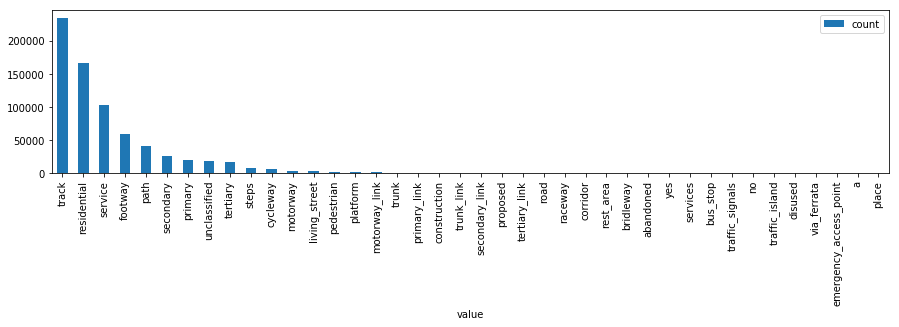

In [295]:
highways_pandas.plot(x='value', y='count', kind='bar',figsize=(15,3))